## <center>Part 1: Scraping Wikipedia for the postal codes in Toronto, and the boroughs & neighborhoods corresponding to each postal code</center>

In [235]:
# Import the required libraries.
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

In [236]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

tor_neigh_scrape = requests.get(url).text
soup = BeautifulSoup(tor_neigh_scrape, 'html5lib') # Convert the scraped text into a BeautifulSoup object.

In [237]:
tor_neigh_contents = []
tor_neigh = soup.find('table')
for row in tor_neigh.findAll('td'):
    cell = {}
    # Looking through the table on Wikipedia, only boroughs have "Not assigned" values, not neighborhoods.
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3] # The postal code of a borough is the first three characters.
        cell['Borough'] = (row.span.text).split('(')[0] # The borough name is then everything until the '(' character.
        # The neighborhood name is formed from the characters after '(', stripping and replacing unnecessary characters.
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        tor_neigh_contents.append(cell)

df = pd.DataFrame(tor_neigh_contents)
# Replace strangely-formatted borough names.
df['Borough'] = df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade': 'Downtown Toronto Stn A',
                                       'East TorontoBusiness reply mail Processing Centre969 Eastern': 'East Toronto Business',
                                       'EtobicokeNorthwest': 'Etobicoke Northwest',
                                       'East YorkEast Toronto': 'East York/East Toronto',
                                       'MississaugaCanada Post Gateway Processing Centre': 'Mississauga'})

In [238]:
df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto Business,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


**<center>There seems to be no need to group neighborhoods corresponding to a single postal code, since Wikipedia has already done this.</center>**

In [239]:
print("The number of rows in the dataframe is " + str(df.shape[0]) + ".")

The number of rows in the dataframe is 103.


## <center>Part 2: Getting the latitude and longitude coordinates of each neighborhood</center>

In [240]:
#import geocoder
#from geopy.geocoders import Nominatim

#latitudes = []
#longitudes = []

#for code in df['PostalCode']:
#    g = geocoder.arcgis('{}, Toronto, Ontario'.format(code))
#    while (g.latlng is None):
#        g = geocoder.arcgis('{}, Toronto, Ontario'.format(code))
#        latlng = g.latlng
#        latitudes.append(latlng[0])
#        longitudes.append(latlng[1])

**<center>Could not make it work using Nominatim; most addresses could not be found, returning a NoneType object. Using the arcgis API was successful, but the latitudes and longitudes returned were slightly different from those in the csv, so decided to use the csv for consistency.</center>**

In [241]:
coordinates = pd.read_csv('Geospatial_Coordinates.csv', header=0)
# Rename the 'Postal Code' column in the csv so that it matches with the column in the existing dataframe.
coordinates.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
# Merge the two dataframes, performing an inner join on the 'PostalCode' column.
merged_df = df.merge(coordinates, how='inner', on ='PostalCode')

In [242]:
merged_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


## <center>Part 3: Exploring and clustering the neighborhoods in Toronto</center>

In [243]:
# Import required libraries
from geopy.geocoders import Nominatim
import folium

In [244]:
# Get Toronto's coordinates.
address = 'Toronto, Canada'
geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latit = location.latitude
longit = location.longitude

# Create a map of Toronto.
map_toronto = folium.Map(location=[latit, longit], zoom_start=10)

# Add postal code markers to the map.
for lat, lng, borough, neighborhood in zip(merged_df['Latitude'], merged_df['Longitude'], merged_df['Borough'],
                                           merged_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [247]:
# Define a function to get venues within a certain radius of a coordinate.
def getNearbyVenues(neighborhoods, latitudes, longitudes, radius=500):
    venues_list=[]
    for neigh, lat, lng in zip(neighborhoods, latitudes, longitudes):        
        # Create the Foursquare API request URL.
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)    
        # Send the GET request.
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # Return relevant information for each nearby venue.
        venues_list.append([(
            neigh, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    # Create a DataFrame from this list with appropriate column names.
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [248]:
# Get nearby venues for each neighborhood in Toronto.
toronto_venues = getNearbyVenues(neighborhoods=merged_df['Neighborhood'], latitudes=merged_df['Latitude'],
                                   longitudes=merged_df['Longitude'])

In [249]:
print(toronto_venues.shape)
toronto_venues.head()

(2123, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Parkwoods,43.753259,-79.329656,GreenWin pool,43.756232,-79.333842,Pool
4,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena


In [250]:
# Get an idea of how many venues are there in each neighborhood.
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
...,...,...,...,...,...,...
Willowdale West,5,5,5,5,5,5
"Willowdale, Newtonbrook",1,1,1,1,1,1
Woburn,3,3,3,3,3,3


In [253]:
# One-hot encode the different categories of venues for each result. 
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
# Reformat the dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

In [254]:
# Group the venues by neighbourhood, and calculate how many venues of each category are there on average.
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [255]:
toronto_grouped.shape

(100, 273)

In [ ]:
# Function to find the top n venue categories in a neighborhood.
def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [256]:
# Find out the top 10 venue categories in each neighbourhood.
num_top = 10

column_names = []

for i in np.arange(0, num_top):
    column_names.append("Venue Rank {}".format(i+1))

# Create a new dataframe to contain this list.
neighborhoods_venues_sorted = pd.DataFrame(columns=column_names)
neighborhoods_venues_sorted.insert(0, 'Neighborhood', toronto_grouped['Neighborhood'])

for ind in toronto_grouped.index:
    neighborhoods_venues_sorted.iloc[ind, 1:] = most_common_venues(toronto_grouped.iloc[ind, :], num_top)
    
neighborhoods_venues_sorted.head()

,Neighborhood,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
0,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Skating Rink,Men's Store,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant,Metro Station
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Gym,Pharmacy,Sandwich Place,Pub,Metro Station,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Middle Eastern Restaurant,Sushi Restaurant,Supermarket,Fried Chicken Joint,Bridal Shop,Shopping Mall,Sandwich Place,Pharmacy
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Yoga Studio
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Sandwich Place,Comfort Food Restaurant,Toy / Game Store,Sushi Restaurant,Pub,Indian Restaurant,Thai Restaurant,Café


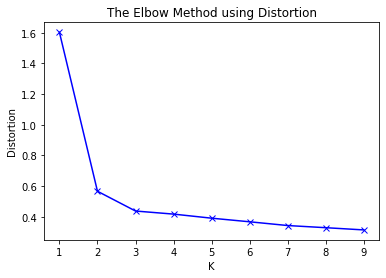

In [286]:
# Determine the optimal number of clusters to use in the k-Means model using the elbow method.
# Drop the column with neighborhood names so that clustering can be done based only on venues.
from scipy.spatial.distance import cdist

toronto_grouped_clusters = toronto_grouped.drop('Neighborhood', axis=1)

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [288]:
k_clusters = 3 # Picked from figure above.

toronto_grouped_clusters = toronto_grouped.drop('Neighborhood', axis=1)

k_means = KMeans(n_clusters = k_clusters).fit(toronto_grouped_clusters)

k_labels = k_means.labels_

k_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 2, 1, 0, 1, 1, 1, 0, 1, 1, 0])

In [289]:
# Add the cluster labels to the DataFrame containing ranked venue categories for each neighborhood.
# We will now know neighborhood-cluster label pairings. 
if 'Cluster Labels' in neighborhoods_venues_sorted.columns:
    neighborhoods_venues_sorted.drop(['Cluster Labels'], axis = 1, inplace = True)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', k_labels)
neighborhoods_venues_sorted.head()

toronto_merged = merged_df

toronto_merged = pd.merge(left = toronto_merged, right = neighborhoods_venues_sorted, on ='Neighborhood')

print(toronto_merged.shape)
toronto_merged.head()

(100, 16)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
0,M3A,North York,Parkwoods,43.753259,-79.329656,1,Fast Food Restaurant,Food & Drink Shop,Pool,Park,Historic Site,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,Portuguese Restaurant,French Restaurant,Hockey Arena,Coffee Shop,Yoga Studio,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Park,Pub,Bakery,Theater,Café,Breakfast Spot,Yoga Studio,Bank,Shoe Store
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1,Furniture / Home Store,Clothing Store,Event Space,Athletics & Sports,Gift Shop,Coffee Shop,Boutique,Vietnamese Restaurant,Accessories Store,Medical Center
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,1,Coffee Shop,Café,Sushi Restaurant,Mexican Restaurant,Beer Bar,Fried Chicken Joint,Spa,Park,Smoothie Shop,Burrito Place


**<center>Map of Toronto showing the result of k-Means clustering on its neighborhoods.</center>**

In [290]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latit, longit], zoom_start=11)


x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [291]:
import seaborn as sns

In [292]:
# Function to count the top venue categories that appear in each cluster.
def top_venue_types(cluster, num_of_venues):
    cluster_columns = [col for col in cluster.columns if col.startswith('Venue Rank')]
    cluster_top = cluster[cluster_columns].stack().value_counts().to_frame().reset_index()
    cluster_top.rename(columns={'index':'venue_type', 0:'count'}, inplace = True)
    cluster_topx = cluster_top.head(num_of_venues)
    
    return cluster_topx

In [293]:
# Function that creates a bar graph of the top venue categories that appear in each cluster.
def plot_top_venues(cluster_top_venues, cluster_num):
    fig = plt.figure(figsize = (10,5))
    splot = sns.barplot(x = 'count', y = 'venue_type', data = cluster_top_venues, palette = 'colorblind')
    title = "Most Common Venues in Cluster {}".format(cluster_num)   
    plt.title(label = title, size = 16)
    plt.xlabel("Count", size = 14)
    plt.ylabel("Venue Type", size = 14)
    for index, value in enumerate(cluster_top_venues['count']):
        label = value
        plt.annotate(label, xy = (value+0.01, index+0.1))
    plt.show()

**<center>There are 3 clusters. Let's see what the statistics are like for each of them.</center>**

**<center>Cluster 0</center>**

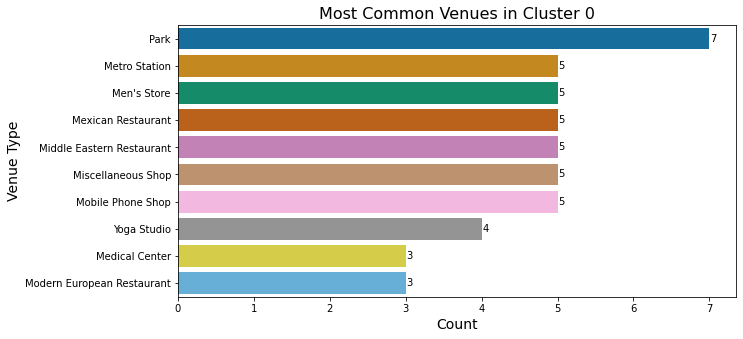

In [298]:
clust0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0,
                            toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

clust0_top10 = top_venue_types(clust0, 10)
clust0_top10

plot_top_venues(clust0_top10, 0)

**<center>Cluster 1</center>**

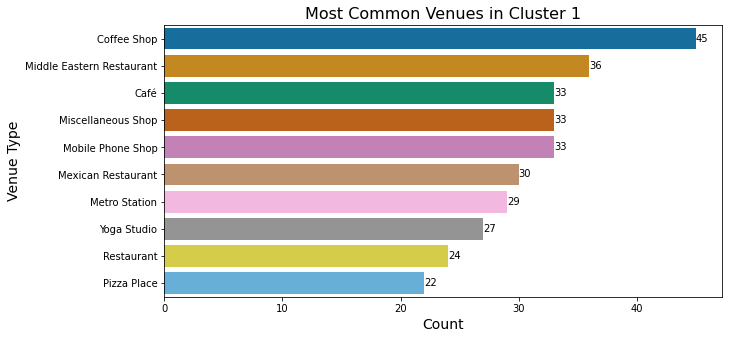

In [299]:
clust1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1,
                            toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

clust1_top10 = top_venue_types(clust1, 10)
clust1_top10

plot_top_venues(clust1_top10, 1)

**<center>Cluster 2</center>**

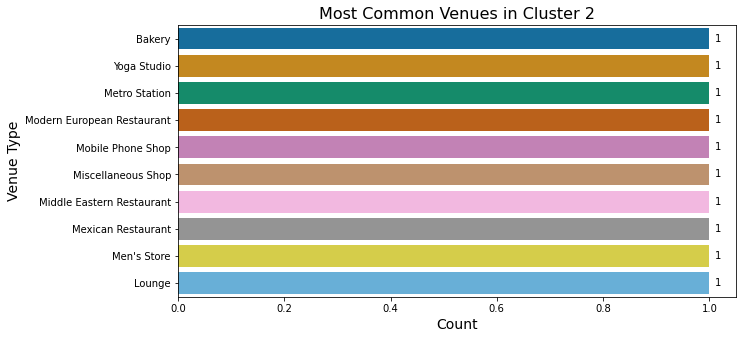

In [300]:
clust2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2,
                            toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

clust2_top10 = top_venue_types(clust2, 10)
clust2_top10

plot_top_venues(clust2_top10, 2)

- _<center>Cluster 0 contains a few **upper-scale** amenities, like a men's clothing stores, parks, a couple of electronics stores, yoga studios, medical centres, and European restaurants.</center>_

- _<center>Cluster 1 seems to have a **lot of gastronomic venues**: restaurants serving various cuisines, as well as cafes. However, from the map, this is the largest cluster, and it is also spread acress Toronto, so this is not too surprising.</center>_

- _<center>Cluster 2 seems to have a **mix of mid- and upper-scale venues**: a few restaurants, a bakery, a lounge etc.</center>_